# Deep Learning & Cryptocurrencies

Pensé que este era un concepto completamente único, combinar aprendizaje profundo y criptomonedas, pero al investigar [esta publicación](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb) encontré algo bastante similar. Esa publicación solo se referirá a Bitcoin (la criptografía más famosa de todas), pero también hablaré de Ethereum (comúnmente conocido como ether, eth o lambo-money).

Vamos a emplear un modelo de Memoria a Largo Plazo Largo (LSTM); es un tipo particular de modelo de aprendizaje profundo que se adapta bien a datos de series de tiempo (o cualquier dato con orden temporal / espacial / estructural, por ejemplo, series temporales, señales de voz, etc.). 

### Datos
Antes de construir el modelo, necesitamos obtener algunos datos para ello. Hay un conjunto de datos en Kaggle que detalla los precios de Bitcoin minuto a minuto (además de algunos otros factores) en los últimos años (presentados en esa otra publicación del blog). En este período de tiempo, el ruido podría saturar la señal, por lo que optaremos por los precios diarios. El problema aquí es que es posible que no tengamos suficientes datos (tendremos cientos de filas en lugar de miles o millones). En aprendizaje profundo, ningún modelo puede superar una grave falta de datos. Tampoco quiero confiar en los archivos estáticos, ya que eso complicará el proceso de actualización del modelo en el futuro con nuevos datos. En su lugar, intentaremos extraer datos de sitios web y API.

Como combinaremos varios criptos en un modelo, probablemente sea una buena idea extraer los datos de una fuente. Usaremos coinmarketcap.com. Por ahora, solo consideraremos Bitcoin y Ether, pero no sería difícil agregar más criptomonedas usando este enfoque. Antes de importar los datos, debemos cargar algunos paquetes de Python que harán nuestras vidas mucho más fáciles.

In [43]:
#Importamos librerias
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

#Librerias para hacer uso de bokeh
!pip install lxml

# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()


,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2018-07-15,6272.70,6403.46,6256.51,6359.64,3285460000,107573000000
1,2018-07-14,6247.50,6298.19,6212.22,6276.12,2923670000,107130000000
2,2018-07-13,6235.03,6310.55,6192.24,6238.05,3805400000,106906000000
3,2018-07-12,6396.78,6397.10,6136.42,6228.81,3770170000,109667000000
4,2018-07-11,6330.77,6444.96,6330.47,6394.71,3644860000,108525000000


In [44]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2018-07-15,435.88,454.00,433.92,449.85,1350160000,43890800000
1,2018-07-14,434.51,439.43,431.47,436.09,1235820000,43743700000
2,2018-07-13,430.74,442.36,430.74,434.03,1489670000,43355400000
3,2018-07-12,446.50,446.50,422.81,430.07,1495440000,44932700000
4,2018-07-11,434.51,447.32,429.51,446.52,1422470000,43717400000


Para explicar lo que acaba de suceder, hemos cargado algunos paquetes de Python y luego importamos la tabla que ve en este sitio. Con un poco de limpieza de datos, llegamos a la tabla de arriba. También hacemos lo mismo para ethereum simplemente reemplazando 'bitcoin' con 'ethereum' en la url.

Para demostrar que los datos son precisos, podemos trazar el precio y el volumen de ambos criptos a lo largo del tiempo.

In [0]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [0]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

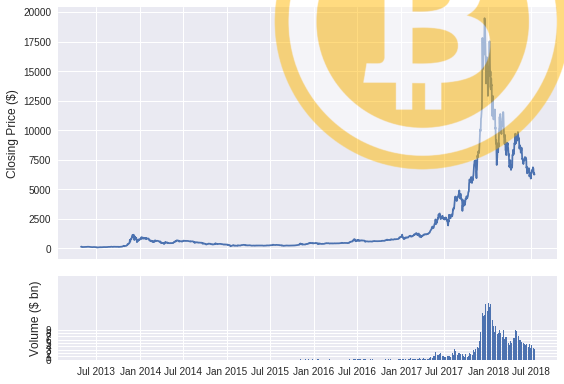

In [47]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open*'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()

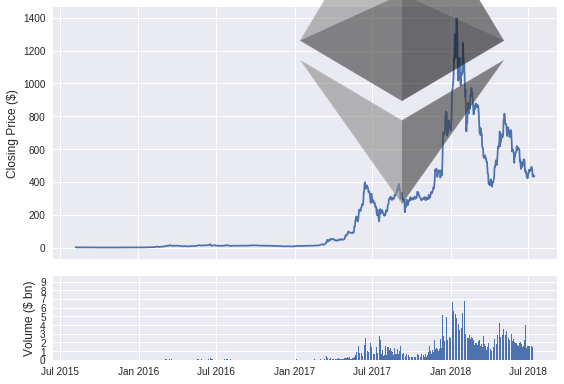

In [48]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open*'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 300, 180, zorder=3, alpha=.6)
plt.show()

In [49]:
market_info  = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close**']-x[coins+'Open*'])/x[coins+'Open*']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open*,bt_High,bt_Low,bt_Close**,bt_Volume,bt_Market Cap,eth_Open*,eth_High,eth_Low,eth_Close**,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-07-15,6272.70,6403.46,6256.51,6359.64,3285460000,107573000000,435.88,454.00,433.92,449.85,1350160000,43890800000,0.013860,0.032050
1,2018-07-14,6247.50,6298.19,6212.22,6276.12,2923670000,107130000000,434.51,439.43,431.47,436.09,1235820000,43743700000,0.004581,0.003636
2,2018-07-13,6235.03,6310.55,6192.24,6238.05,3805400000,106906000000,430.74,442.36,430.74,434.03,1489670000,43355400000,0.000484,0.007638
3,2018-07-12,6396.78,6397.10,6136.42,6228.81,3770170000,109667000000,446.50,446.50,422.81,430.07,1495440000,44932700000,-0.026259,-0.036797
4,2018-07-11,6330.77,6444.96,6330.47,6394.71,3644860000,108525000000,434.51,447.32,429.51,446.52,1422470000,43717400000,0.010100,0.027640


## Entrenamiento, prueba y paseos aleatorios

Tenemos algunos datos, así que ahora necesitamos construir un modelo. En el aprendizaje profundo, los datos generalmente se dividen en conjuntos de entrenamiento y prueba. El modelo se basa en el conjunto de entrenamiento y posteriormente se evalúa en el conjunto de pruebas no vistas. En los modelos de series temporalmente, generalmente entrenamos en un período de tiempo y luego evaluamos en otro período separado. De manera bastante arbitraria, estableceré la fecha límite para el 1 de junio de 2017 (es decir, el modelo recibirá capacitación sobre los datos antes de esa fecha y se evaluarán los datos posteriores).


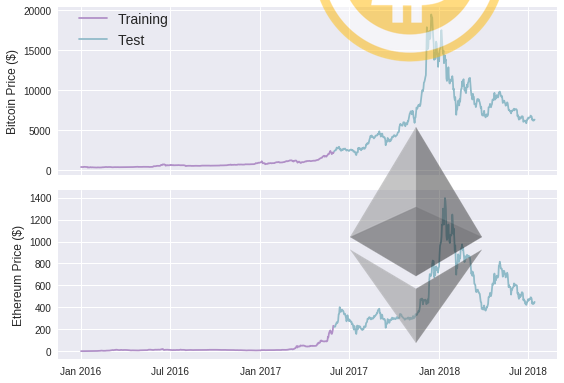

In [50]:
split_date = '2017-06-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close**'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close**'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close**'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close**'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 260, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 40, zorder=3,alpha=.5)
plt.show()

Puede ver que el período de entrenamiento consiste principalmente en períodos en los que los criptos eran relativamente más baratos. Como tal, los datos de entrenamiento pueden no ser representativos de los datos de prueba, lo que socava la capacidad del modelo para generalizar a datos no vistos (podría tratar de hacer que sus datos permanezcan estacionarios, discutidos aquí). Pero, ¿por qué dejar que las realidades negativas se interpongan en el camino del optimismo sin fundamento? Antes de llevar nuestro modelo de aprendizaje automático artificialmente inteligente a la Luna, vale la pena discutir un modelo más simple. El modelo más básico es establecer el precio de mañana igual al precio de hoy (que llamaremos crudamente un modelo de retraso). Así es como definiríamos dicho modelo en términos matemáticos:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1}
\end{align}

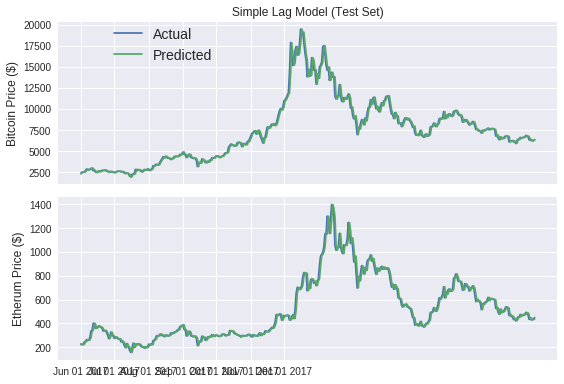

In [51]:
# trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close**'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close**'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close**'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close**'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

Extendiendo este modelo trivial de retraso, [los precios de las acciones se tratan comúnmente como paseos aleatorios] (https://www.tcd.ie/Economics/assets/pdf/SER/2007/Samuel_Dupernex.pdf), que se puede definir en estos términos matemáticos. :

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)
\end{align}

Determinaremos & mu; y & sigma; de los conjuntos de entrenamiento y aplicar el modelo de paseo aleatorio a los conjuntos de pruebas de Bitcoin y Ethereum.

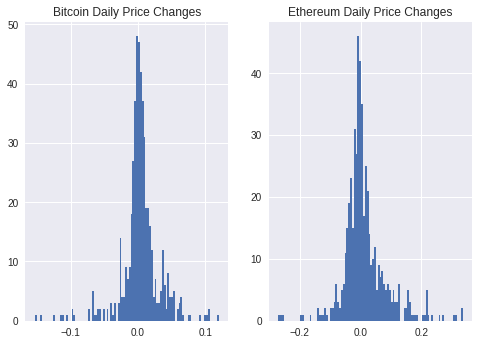

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

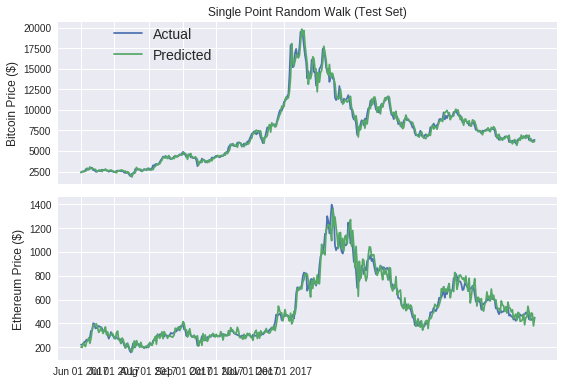

In [53]:
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close**'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close**'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close**'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close**'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

¡Guauu! Mira esas líneas de predicción. Aparte de algunas fallas, en términos generales sigue el precio real de cierre de cada moneda. Incluso captura las subidas de eth (y caídas posteriores) a mediados de junio y finales de agosto. En esta etapa, si tuviera que anunciar el lanzamiento de sheehanCoin, estoy seguro de que ICO se suscribió estúpidamente. Como se señaló en ese otro blog, los modelos que solo hacen predicciones en un punto en el futuro a menudo son engañosamente precisos, ya que los errores no se trasladan a predicciones posteriores. No importa cuán grande sea el error, esencialmente se restablece en cada punto de tiempo, ya que el modelo se alimenta con el precio real. La caminata aleatoria de Bitcoin es particularmente engañosa, ya que la escala del eje y es bastante amplia, lo que hace que la línea de predicción parezca bastante suave.

Las predicciones de punto único son desafortunadamente bastante comunes cuando se evalúan modelos de series temporales (por ejemplo, [aquí](https://medium.com/@binsumi/neural-networks-and-bitcoin-d452bfd7757e) y [aquí](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)). Una mejor idea podría ser medir su precisión en predicciones multipunto. De esta forma, los errores de las predicciones anteriores no se restablecen, sino que se combinan con predicciones posteriores. Por lo tanto, los modelos pobres son penalizados más fuertemente. En términos matemáticos:

\begin{align}
PredPrice_{t} & = PredPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)\ \&  \ PredPrice_0 = Price_0
\end{align}

Vamos a obtener nuestro modelo de paseo aleatorio para predecir los precios de cierre sobre el conjunto de prueba total.

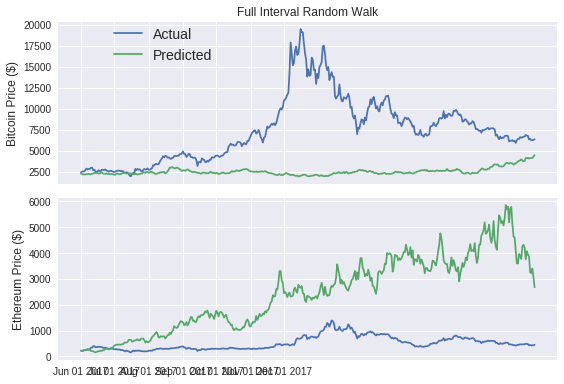

In [54]:

bt_random_walk  = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close**'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close**'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close**'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         bt_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close**'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         eth_random_walk[::-1], label='Predicted')

ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

Las predicciones del modelo son extremadamente sensibles a la semilla aleatoria. Seleccioné uno donde la caminata aleatoria de intervalo completo parece casi decente para Ethereum. En el [cuaderno Jupyter que acompaña](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb), puede interactivamente juegue con el valor de la semilla a continuación para ver qué tan mal puede funcionar.

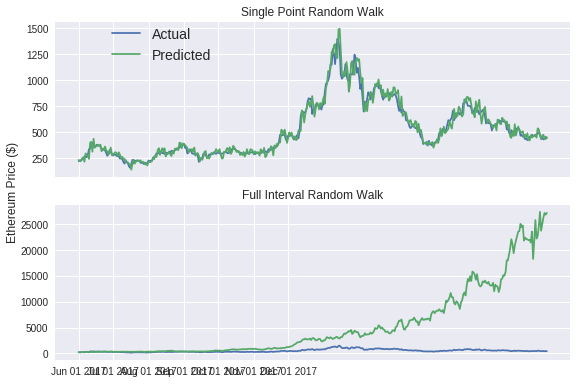

<function __main__.plot_func>

In [55]:
!pip install ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_func(freq):
    np.random.seed(freq)
    random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
    random_walk = []
    for n_step,i in enumerate(random_steps):
        if n_step==0:
            random_walk.append(market_info[market_info['Date']< split_date]['eth_Close**'].values[0] * (i+1))
        else:
            random_walk.append(random_walk[n_step-1] * (i+1))
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
    ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close**'].values, label='Actual')
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close**'].values[1:] * 
         (1+random_steps), label='Predicted')
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close**'].values[1:] * 
         (1+random_steps))
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
             random_walk[::-1])
    ax1.set_title('Single Point Random Walk')
    ax1.set_ylabel('')
    # for static figures, you may wish to insert the random seed value
#    ax1.annotate('Random Seed: %d'%freq, xy=(0.75, 0.2),  xycoords='axes fraction',
#            xytext=(0.75, 0.2), textcoords='axes fraction')
    ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax2.set_title('Full Interval Random Walk')
    fig.text(0.0, 0.5, 'Ethereum Price ($)', va='center', rotation='vertical',fontsize=12)
    plt.tight_layout()
#    plt.savefig('image%d.png'%freq, bbox_inches='tight')
    plt.show()
    
interact(plot_func, freq =widgets.IntSlider(min=200,max=210,step=1,value=205, description='Random Seed:'))

Observe cómo la caminata aleatoria de un solo punto siempre se ve bastante precisa, a pesar de que no hay una sustancia real detrás de ella. Con suerte, será más sospechoso de cualquier blog que pretenda predecir con precisión los precios. Probablemente no debería preocuparme; no es como los fanáticos de la criptografía ser seducidos por [reclamos de marketing ingenioso](https://uetoken.com/).

## Long Short term Memory (LSTM)

Como dije, si está interesado en la teoría detrás de los LSTM, lo referiré a estos enlaces [1](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [2](http://blog.echen.me/2017/05/30/exploring-lstms/) y [this] (http://www.bioinf.jku.at/publications/older/2604.pdf). Afortunadamente, no necesitamos construir la red desde cero (ni siquiera entenderla), existen paquetes que incluyen implementaciones estándar de varios algoritmos de aprendizaje profundo (por ejemplo, [TensorFlow](https://www.tensorflow.org/get_started/). get_started), [Keras](https://keras.io/#keras-the-python-deep-learning-library), [PyTorch](http://pytorch.org/), etc.). Optaré por Keras, ya que lo encuentro más intuitivo para los no expertos. Si no está familiarizado con Keras, entonces consulte mi [tutorial anterior](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network- principiantes /).

In [0]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close**'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open*'])}
    market_info = market_info.assign(**kwargs)

In [57]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close**','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close**,bt_Volume,bt_close_off_high,bt_volatility,eth_Close**,eth_Volume,eth_close_off_high,eth_volatility
926,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
925,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
924,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
923,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
922,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


Creé un nuevo marco de datos llamado `model_data`. Eliminé algunas de las columnas anteriores (precio abierto, máximos y mínimos diarios) y reformulé algunas nuevas. `close_off_high` representa la brecha entre el precio de cierre y el precio alto para ese día, donde los valores de -1 y 1 significan que el precio de cierre fue igual al mínimo diario o máximo diario, respectivamente. Las columnas `volatilidad` son simplemente la diferencia entre el precio alto y el precio bajo dividido por el precio de apertura. También puede observar que `model_data` está organizado por orden de más temprano a más reciente. En realidad, ya no necesitamos la columna de fecha, ya que esa información no se ingresará en el modelo.

Nuestro modelo LSTM utilizará datos previos (tanto bitcoin como eth) para predecir el precio de cierre del día siguiente de una moneda específica. Debemos decidir a cuántos días previos tendrá acceso. De nuevo, es bastante arbitrario, pero optaré por 10 días, ya que es un buen número redondo. Construimos pequeños marcos de datos que constan de 10 días consecutivos de datos (llamados ventanas), por lo que la primera ventana consistirá en las filas 0-9 del conjunto de capacitación (Python tiene índice cero), la segunda serán las filas 1-10. , etc. Elegir un tamaño de ventana pequeño significa que podemos enviar más ventanas a nuestro modelo; La desventaja es que el modelo puede no tener suficiente información para detectar comportamientos complejos a largo plazo (si tales cosas existen).

A los modelos de aprendizaje profundo no les gustan los aportes que varían ampliamente. Al mirar esas columnas, algunos valores oscilan entre -1 y 1, mientras que otros están en la escala de millones. Necesitamos normalizar los datos, de modo que nuestras aportaciones sean algo consistentes. Normalmente, desea valores entre -1 y 1. Las columnas `off_high` y` volatility` están bien tal como están. Para las columnas restantes, como esa [otra publicación de blog](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price), normalizaremos las entradas al primer valor en la ventana.

In [0]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [0]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close**','Volume']]

In [0]:

LSTM_training_inputs  = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close**'][window_len:].values/training_set['eth_Close**'][:-window_len].values)-1

In [0]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close**'][window_len:].values/test_set['eth_Close**'][:-window_len].values)-1

In [62]:
LSTM_training_inputs[0]

,bt_Close**,bt_Volume,bt_close_off_high,bt_volatility,eth_Close**,eth_Volume,eth_close_off_high,eth_volatility
926,0.000000,0.000000,-0.560641,0.020292,0.000000,0.000000,-0.418477,0.025040
925,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
924,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
923,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
922,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
921,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
920,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
919,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
918,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
917,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


Esta tabla representa un ejemplo de nuestra entrada de modelo LSTM (en realidad tendremos cientos de tablas similares). Hemos normalizado algunas columnas para que sus valores sean iguales a 0 en el primer punto de tiempo, por lo que pretendemos predecir los cambios en el precio en relación con este punto de tiempo. Ahora estamos listos para construir el modelo LSTM. En realidad, es bastante sencillo con Keras, simplemente se apilan los componentes uno encima del otro (mejor explicado [aquí](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial- for-neural-network-beginners /)).

In [0]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [64]:
# import the relevant Keras modules
!pip install keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


Entonces, las funciones `build_model` construyen un modelo vacío llamado imaginativo modelo (` modelo = Secuencial`), al que se agrega una capa LSTM. Esa capa se ha configurado para ajustarse a nuestras entradas (tablas n x m, donde n y m representan el número de puntos de tiempo / filas y columnas, respectivamente). La función también incluye características más genéricas de redes neuronales, como [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) y [funciones de activación](https: //dashee87.github. io / data% 20science / deep% 20learning / visualizing-activation-functions-in-neural-networks /). Ahora, solo necesitamos especificar el número de neuronas que se colocarán en la capa LSTM (he optado por 20 para mantener el tiempo de ejecución razonable), así como los datos sobre los que se entrenará al modelo.

In [0]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [66]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close**'][window_len:].values/training_set['eth_Close**'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 13s - loss: 0.1648
Epoch 2/50
 - 12s - loss: 0.1131
Epoch 3/50
 - 13s - loss: 0.1065
Epoch 4/50
 - 13s - loss: 0.0947
Epoch 5/50
 - 13s - loss: 0.0871
Epoch 6/50
 - 12s - loss: 0.0840
Epoch 7/50
 - 12s - loss: 0.0831
Epoch 8/50
 - 12s - loss: 0.0810
Epoch 9/50
 - 12s - loss: 0.0777
Epoch 10/50
 - 12s - loss: 0.0783
Epoch 11/50
 - 13s - loss: 0.0744
Epoch 12/50
 - 12s - loss: 0.0747
Epoch 13/50
 - 12s - loss: 0.0741
Epoch 14/50
 - 12s - loss: 0.0702
Epoch 15/50
 - 12s - loss: 0.0689
Epoch 16/50
 - 12s - loss: 0.0686
Epoch 17/50
 - 12s - loss: 0.0744
Epoch 18/50
 - 12s - loss: 0.0682
Epoch 19/50
 - 12s - loss: 0.0697
Epoch 20/50
 - 12s - loss: 0.0693
Epoch 21/50
 - 12s - loss: 0.0688
Epoch 22/50
 - 12s - loss: 0.0701
Epoch 23/50
 - 12s - loss: 0.0668
Epoch 24/50
 - 12s - loss: 0.0670
Epoch 25/50
 - 12s - loss: 0.0683
Epoch 26/50
 - 13s - loss: 0.0651
Epoch 27/50
 - 12s - loss: 0.0655
Epoch 28/50
 - 12s - loss: 0.0640
Epoch 29/50
 - 12s - loss: 0.0679
Epoch 30/50
 - 12s - lo

Si todo fue según lo planeado, entonces esperaríamos que el error de entrenamiento haya disminuido gradualmente con el tiempo.

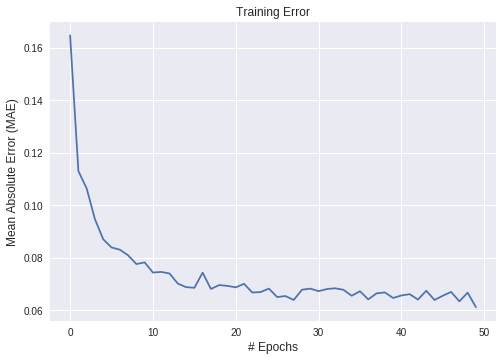

In [67]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

Acabamos de construir un modelo LSTM para predecir el precio de cierre de Ethereum en el futuro. Veamos qué tan bien funciona. Comenzamos examinando su desempeño en el conjunto de capacitación (datos anteriores a junio de 2017). Ese número debajo del código representa el error absoluto medio del modelo (mae) en el conjunto de entrenamiento después de la 50 iteraciones de entrenamiento (o época). En lugar de cambios relativos, podemos ver el resultado del modelo como precios de cierre diarios.

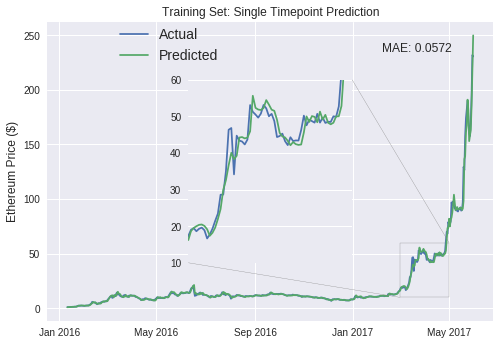

In [68]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close**'].values[window_len:])/(training_set['eth_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close**'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close**'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()


No deberíamos sorprendernos demasiado por su aparente precisión aquí. El modelo podría acceder al origen de su error y ajustarse en consecuencia. De hecho, no es difícil alcanzar casi cero errores de entrenamiento. Podríamos meter cientos de neuronas y entrenar durante miles de épocas (un proceso conocido como sobreajuste, donde esencialmente se está prediciendo ruido). Incluí la llamada `Dropout ()` en la función `build_model` para mitigar este riesgo para nuestra modelo relativamente pequeño). Deberíamos estar más interesados en su desempeño en el conjunto de datos de prueba, ya que esto representa datos completamente nuevos para el modelo.

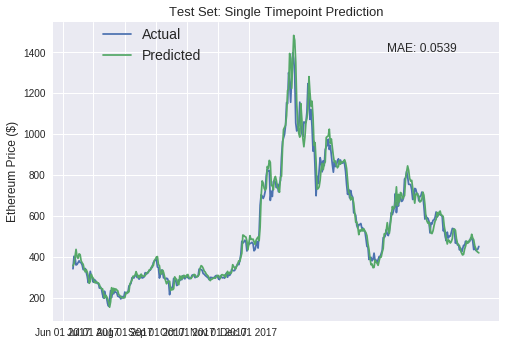

In [69]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close**'].values[window_len:])/(test_set['eth_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Dejando de lado las advertencias sobre la naturaleza engañosa de las predicciones de punto único, nuestro modelo LSTM * parece * haber funcionado bien en el conjunto de pruebas no vistas. La falla más obvia es que no puede detectar la inevitable recesión cuando el precio eth repentinamente se dispara (por ejemplo, a mediados de junio y octubre). De hecho, esta es una falla persistente; es más evidente en estos picos. El precio previsto regularmente parece ser equivalente al precio real que se modificó un día después (por ejemplo, el descenso a mediados de julio). Además, el modelo parece sobrestimar sistémicamente el valor futuro de Ether (unirse al club, ¿no?), Ya que la línea pronosticada casi siempre corre más alta que la línea real. Sospecho que esto se debe a que los datos de entrenamiento representan un período durante el cual el precio del éter aumentó astronómicamente, por lo que espera que la tendencia continúe (no todos). También podemos construir un modelo LSTM similar para Bitcoin: las predicciones de los conjuntos de pruebas se trazan a continuación (consulte [Cuaderno Jupyter para obtener el código completo](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb).

In [70]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close**'][window_len:].values/training_set['bt_Close**'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 13s - loss: 0.1010
Epoch 2/50
 - 12s - loss: 0.0646
Epoch 3/50
 - 12s - loss: 0.0455
Epoch 4/50
 - 12s - loss: 0.0421
Epoch 5/50
 - 12s - loss: 0.0372
Epoch 6/50
 - 12s - loss: 0.0324
Epoch 7/50
 - 12s - loss: 0.0305
Epoch 8/50
 - 12s - loss: 0.0326
Epoch 9/50
 - 12s - loss: 0.0311
Epoch 10/50
 - 12s - loss: 0.0300
Epoch 11/50
 - 12s - loss: 0.0268
Epoch 12/50
 - 12s - loss: 0.0284
Epoch 13/50
 - 12s - loss: 0.0270
Epoch 14/50
 - 12s - loss: 0.0280
Epoch 15/50
 - 12s - loss: 0.0280
Epoch 16/50
 - 12s - loss: 0.0267
Epoch 17/50
 - 12s - loss: 0.0263
Epoch 18/50
 - 12s - loss: 0.0261
Epoch 19/50
 - 12s - loss: 0.0257
Epoch 20/50
 - 12s - loss: 0.0257
Epoch 21/50
 - 12s - loss: 0.0247
Epoch 22/50
 - 12s - loss: 0.0241
Epoch 23/50
 - 12s - loss: 0.0245
Epoch 24/50
 - 12s - loss: 0.0256
Epoch 25/50
 - 12s - loss: 0.0241
Epoch 26/50
 - 12s - loss: 0.0251
Epoch 27/50
 - 12s - loss: 0.0245
Epoch 28/50
 - 12s - loss: 0.0235
Epoch 29/50
 - 12s - loss: 0.0243
Epoch 30/50
 - 13s - lo

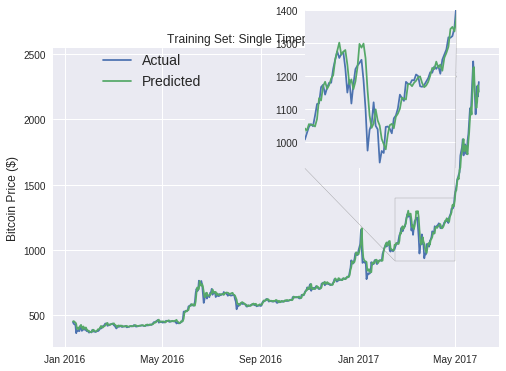

In [71]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close**'].values[window_len:])/(training_set['bt_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close**'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close**'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

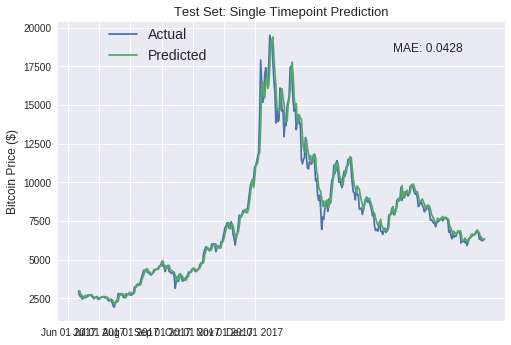

In [72]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close**'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close**'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close**'].values[window_len:])/(test_set['bt_Close**'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Como dije anteriormente, las predicciones de punto único pueden ser engañosas. Si observa más de cerca, observará que, una vez más, los valores predichos reflejan regularmente los valores anteriores (por ejemplo, octubre). Nuestro sofisticado modelo LSTM de aprendizaje profundo ha reproducido parcialmente un modelo [autregresivo (AR)](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) de algún orden `p `, donde los valores futuros son simplemente la suma ponderada de los valores` p` anteriores. Podemos definir un modelo AR en estos términos matemáticos:

\begin{align}
PredPrice_{t} & = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}

La buena noticia es que los modelos AR se emplean comúnmente en tareas de series de tiempo (p. Ej., [Precios del mercado de valores](https://upcommons.upc.edu/bitstream/handle/2099/3572/04marcek.pdf)), por lo que el modelo LSTM parece haber aterrizado en una solución sensata. La mala noticia es que es un desperdicio de las capacidades de LSTM, podríamos haber construido un modelo de RA mucho más simple en mucho menos tiempo y probablemente hubiésemos logrado resultados similares (aunque el título de esta publicación habría sido mucho menos clickbaity). [Más complejo no equivale automáticamente a más precisión](https://pdfs.semanticscholar.org/696c/2fa5697f58914921ff37d69ced44ddea143f.pdf)).

Ahora crearemos modelos LSTM para predecir los precios de criptografía para los próximos 5 días.

In [73]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close**'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close**'][i:i+pred_range].values/
                                  training_set['eth_Close**'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 13s - loss: 0.2214
Epoch 2/50
 - 12s - loss: 0.1575
Epoch 3/50
 - 12s - loss: 0.1441
Epoch 4/50
 - 12s - loss: 0.1379
Epoch 5/50
 - 12s - loss: 0.1285
Epoch 6/50
 - 12s - loss: 0.1256
Epoch 7/50
 - 12s - loss: 0.1242
Epoch 8/50
 - 12s - loss: 0.1266
Epoch 9/50
 - 12s - loss: 0.1202
Epoch 10/50
 - 12s - loss: 0.1200
Epoch 11/50
 - 12s - loss: 0.1170
Epoch 12/50
 - 12s - loss: 0.1199
Epoch 13/50
 - 12s - loss: 0.1158
Epoch 14/50
 - 12s - loss: 0.1178
Epoch 15/50
 - 12s - loss: 0.1176
Epoch 16/50
 - 12s - loss: 0.1193
Epoch 17/50
 - 12s - loss: 0.1150
Epoch 18/50
 - 12s - loss: 0.1169
Epoch 19/50
 - 12s - loss: 0.1162
Epoch 20/50
 - 12s - loss: 0.1151
Epoch 21/50
 - 12s - loss: 0.1134
Epoch 22/50
 - 12s - loss: 0.1117
Epoch 23/50
 - 12s - loss: 0.1127
Epoch 24/50
 - 12s - loss: 0.1106
Epoch 25/50
 - 12s - loss: 0.1146
Epoch 26/50
 - 12s - loss: 0.1107
Epoch 27/50
 - 12s - loss: 0.1127
Epoch 28/50
 - 12s - loss: 0.1111
Epoch 29/50
 - 12s - loss: 0.1125
Epoch 30/50
 - 12s - lo

In [74]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close**'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close**'][i:i+pred_range].values/
                                  training_set['bt_Close**'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 14s - loss: 0.1041
Epoch 2/50
 - 12s - loss: 0.0647
Epoch 3/50
 - 12s - loss: 0.0527
Epoch 4/50
 - 12s - loss: 0.0480
Epoch 5/50
 - 12s - loss: 0.0446
Epoch 6/50
 - 12s - loss: 0.0435
Epoch 7/50
 - 12s - loss: 0.0417
Epoch 8/50
 - 12s - loss: 0.0408
Epoch 9/50
 - 12s - loss: 0.0411
Epoch 10/50
 - 12s - loss: 0.0411
Epoch 11/50
 - 12s - loss: 0.0395
Epoch 12/50
 - 12s - loss: 0.0394
Epoch 13/50
 - 12s - loss: 0.0393
Epoch 14/50
 - 12s - loss: 0.0392
Epoch 15/50
 - 12s - loss: 0.0386
Epoch 16/50
 - 12s - loss: 0.0396
Epoch 17/50
 - 12s - loss: 0.0382
Epoch 18/50
 - 12s - loss: 0.0381
Epoch 19/50
 - 12s - loss: 0.0386
Epoch 20/50
 - 12s - loss: 0.0383
Epoch 21/50
 - 12s - loss: 0.0384
Epoch 22/50
 - 12s - loss: 0.0382
Epoch 23/50
 - 12s - loss: 0.0371
Epoch 24/50
 - 12s - loss: 0.0365
Epoch 25/50
 - 12s - loss: 0.0374
Epoch 26/50
 - 12s - loss: 0.0377
Epoch 27/50
 - 12s - loss: 0.0373
Epoch 28/50
 - 12s - loss: 0.0368
Epoch 29/50
 - 12s - loss: 0.0376
Epoch 30/50
 - 12s - lo

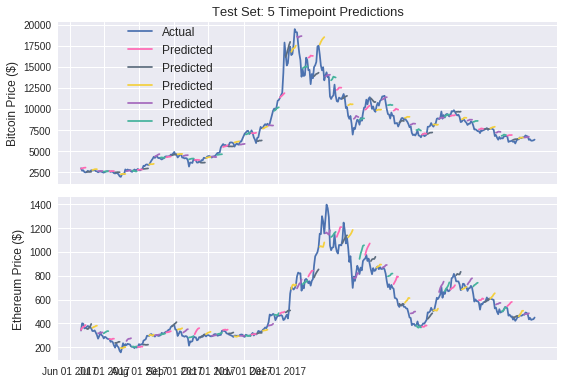

In [75]:

# little bit of reformatting the predictions to closing prices# little 
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close**'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close**'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close**'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close**'][window_len:], label='Actual')
for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

Las predicciones son visiblemente menos impresionantes que sus homólogos de un solo punto. Sin embargo, me complace que el modelo haya arrojado comportamientos algo matizados (por ejemplo, la segunda línea en el gráfico eth); no solo pronosticó que los precios se muevan uniformemente en una dirección. Entonces hay algunos motivos para el optimismo.

Volviendo a las predicciones de punto único, nuestro modelo neuronal artificial de máquina profunda se ve bien, pero también lo hizo ese aburrido modelo de paseo aleatorio. Al igual que el modelo de paseo aleatorio, los modelos LSTM pueden ser sensibles a la elección de la semilla aleatoria (los pesos del modelo se asignan aleatoriamente inicialmente). Entonces, si queremos comparar los dos modelos, ejecutaremos cada uno múltiples (digamos, 25) veces para obtener una estimación del error del modelo. El error se calculará como la diferencia absoluta entre los cambios de precios de cierre reales y previstos en el conjunto de prueba.

In [76]:
# assuming the previous cell was completed, this cell loads in the different initialisations
# and calculates the average mean absolute error (mae)

from keras.models import load_model

eth_preds = []
bt_preds = []
for rand_seed in range(775,800):
    temp_model = load_model('eth_model_randseed_%d.h5'%rand_seed)
    eth_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['eth_Close**'].values[window_len:]/test_set['eth_Close**'].values[:-window_len]-1))))
    temp_model = load_model('bt_model_randseed_%d.h5'%rand_seed)
    bt_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['bt_Close**'].values[window_len:]/test_set['bt_Close**'].values[:-window_len]-1))))

OSError: ignored

In [0]:
eth_random_walk_preds = []
bt_random_walk_preds = []
for rand_seed in range(775,800):
    np.random.seed(rand_seed)
    eth_random_walk_preds.append(
        np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['eth_Close**'][window_len:])/np.array(test_set['eth_Close**'][:-window_len]))))
    bt_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(bt_r_walk_mean, bt_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['bt_Close**'][window_len:])/np.array(test_set['bt_Close**'][:-window_len]))))

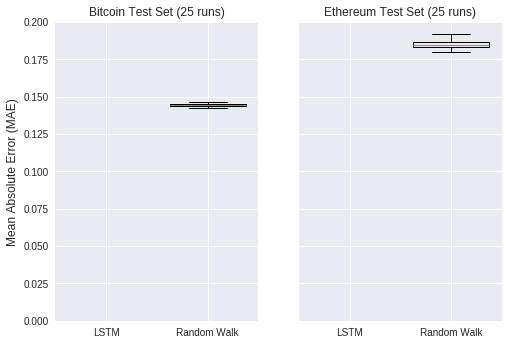

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.boxplot([bt_preds, bt_random_walk_preds],widths=0.75)
ax1.set_ylim([0, 0.2])
ax2.boxplot([eth_preds, eth_random_walk_preds],widths=0.75)
ax2.set_ylim([0, 0.2])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Bitcoin Test Set (25 runs)')
ax2.set_title('Ethereum Test Set (25 runs)')
ax2.set_yticklabels('')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
plt.show()


¡Tal vez la IA valga la exageración después de todo! Esos gráficos muestran el error en el conjunto de prueba después de 25 inicializaciones diferentes de cada modelo. El modelo LSTM arroja un error promedio de aproximadamente 0.04 y 0.05 en los precios de bitcoin y eth, respectivamente, aplastando los modelos de recorrido aleatorio correspondientes.

Con el objetivo de vencer a los paseos aleatorios es una barra bastante baja. Sería más interesante comparar el modelo LSTM con modelos de series de tiempo más apropiadas (promedio ponderado, autorregresión, [ARIMA](https://dashee87.github.io/data%20science/general/A-Road- Incident-Model- Analysis /) o Facebook [algoritmo de Prophet](https://github.com/facebook/prophet)). Por otro lado, estoy seguro de que no sería difícil mejorar nuestro modelo LSTM (agregando gratuitamente más capas y / o neuronas, cambiando el tamaño del lote, la velocidad de aprendizaje, etc.). Dicho esto, espero que haya detectado mi escepticismo cuando se trata de aplicar el aprendizaje profundo para predecir los cambios en los precios de criptografía. Eso es porque estamos pasando por alto el mejor marco de todos: la inteligencia humana. Claramente, el modelo perfecto * para predecir cryptos es:

\begin{align}
& Price^{Crypto}_{t} > Price^{Crypto}_{t-1} \,  \forall \ Crypto \neq OmiseGo \textrm{, }  \\
& \textrm{  where } Price^{Crypto}_{t} \to moon \textrm{, as } t \to    \infty           
\end{align}

* Este blog no constituye asesoramiento financiero y no debe tomarse como tal. Mientras que las inversiones en criptomonedas definitivamente subirán en valor para siempre, también pueden bajar.

## Resumen

Hemos recopilado algunos datos criptográficos y los hemos alimentado en un modelo LSM de aprendizaje de máquinas supercool profundamente inteligente. Desafortunadamente, sus predicciones no fueron tan diferentes de simplemente escupir el valor anterior. ¿Cómo podemos hacer que el modelo aprenda comportamientos más sofisticados?

* ** Función de pérdida de cambio **: MAE realmente no alienta la toma de riesgos. Por ejemplo, en el error medio cuadrático (MSE), el modelo LSTM se vería obligado a dar más importancia a la detección de picos / valles. [Más funciones de pérdida enfocadas en el comercio](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) también podría mover el modelo hacia comportamientos menos conservadores.

* ** Penalizar modelos conservadores de tipo AR **: Esto incentivaría el algoritmo de aprendizaje profundo para explorar modelos más arriesgados / interesantes. ¡Es más fácil decirlo que hacerlo!

* ** Obtener más y / o mejor información **: si los precios pasados ​​por sí solos son suficientes para pronosticar decentemente los precios futuros, debemos incluir otras características que brinden un poder predictivo comparable. De esta forma, el modelo LSTM no dependería tanto de los precios anteriores, lo que podría desbloquear comportamientos más complejos. Esta es probablemente la mejor y más difícil solución.

Si ese es el giro positivo, entonces la realidad negativa es que es muy posible que no haya un patrón detectable para los cambios en los precios de cifrado; que ningún modelo (por profundo que sea) puede separar la señal del ruido (similar a los méritos de usar [aprendizaje profundo para predecir terremotos](https://www.scientificamerican.com/article/can-artificial-intelligence-predict-earthquakes /)). Y cualquier patrón que aparezca [puede desaparecer tan rápido](http://site.iugaza.edu.ps/wdaya/files/2013/03/A-Random-Walk-Down-Wall-Street.pdf) (ver[hipótesis de mercado eficiente](results_merge.click2)). Simplemente piense qué tan diferente es Bitcoin en 2016: montar Bitcoin a finales de 2017. Cualquier modelo basado en datos de 2016 seguramente tendrá dificultades para reproducir estos movimientos sin precedentes. Todo esto sugiere que también podría ahorrarse algo de tiempo y atenerse a la autorregresión (a menos que esté escribiendo un blog, por supuesto).

Pero estoy seguro de que eventualmente encontrarán algunos casos de uso para el aprendizaje profundo. Mientras tanto, puedes construir tu propio modelo de LSTM descargando el código de Python [aquí](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb). ¡Gracias por leer!